In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
df1 = pd.read_excel('solar_data_1.xlsx', engine='openpyxl')
df2 = pd.read_excel('solar_data_2.xlsx', engine='openpyxl')
df = pd.concat([df1, df2], axis=0)
df.head()

,state_name,number_of_panels_total,kw_total,kw_median,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,existing_installs_count
0,NaN,31,7.75,3.25,5209.464685,1.243764e+04,0.0
1,Alabama,58997532,14749383.00,9.75,12069.322656,1.896138e+10,549.0
2,Alaska,2179124,544781.00,7.25,6540.612622,4.664927e+08,83.0
3,Arizona,114697808,28674452.00,11.75,18974.796637,4.639329e+10,39553.0
4,Arkansas,28130196,7032549.00,9.75,12099.947974,8.941609e+09,238.0


Start with some EDA

In [3]:
# it's small data
df.shape

(55, 7)

In [4]:
# we have a few missing values
# the datatypes look to be correct
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 33
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   state_name                  54 non-null     object 
 1   number_of_panels_total      55 non-null     int64  
 2   kw_total                    55 non-null     float64
 3   kw_median                   54 non-null     float64
 4   yearly_sunlight_kwh_median  54 non-null     float64
 5   yearly_sunlight_kwh_total   55 non-null     float64
 6   existing_installs_count     54 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.4+ KB


In [5]:
df.describe()

,number_of_panels_total,kw_total,kw_median,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,existing_installs_count
count,5.500000e+01,5.500000e+01,54.000000,54.000000,5.500000e+01,54.000000
mean,6.418217e+07,1.604554e+07,7.907407,9952.438422,2.078188e+10,12785.666667
std,9.028737e+07,2.257184e+07,1.963882,3390.644848,3.233178e+10,46522.857045
min,3.100000e+01,7.750000e+00,3.250000,5156.452783,1.243764e+04,0.000000
25%,1.704436e+07,4.261089e+06,6.750000,7350.628174,5.982309e+09,357.000000
50%,4.847139e+07,1.211785e+07,7.750000,9409.792603,1.481478e+10,1727.000000
75%,7.325589e+07,1.831397e+07,9.000000,11375.480533,2.074348e+10,5994.500000
max,5.310227e+08,1.327557e+08,13.000000,19004.649878,1.980163e+11,328899.000000


In [6]:
df['state_name'].unique().shape

(52,)

In [7]:
# we have a missing value and DC with the other 50 states
df['state_name'].unique()

array([nan, 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

array([[<AxesSubplot:title={'center':'number_of_panels_total'}>,
        <AxesSubplot:title={'center':'kw_total'}>],
       [<AxesSubplot:title={'center':'kw_median'}>,
        <AxesSubplot:title={'center':'yearly_sunlight_kwh_median'}>],
       [<AxesSubplot:title={'center':'yearly_sunlight_kwh_total'}>,
        <AxesSubplot:title={'center':'existing_installs_count'}>]],
      dtype=object)

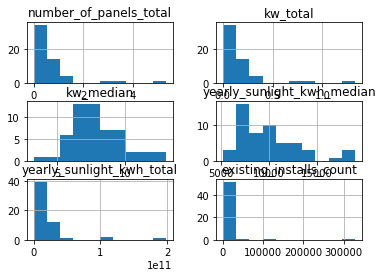

In [8]:
# we have one normal-looking distribution, the others look skewed heavy to the left
df.hist()

In [9]:
# about half of the correlations are very strong, the other half are weak
df.corr()

,number_of_panels_total,kw_total,kw_median,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,existing_installs_count
number_of_panels_total,1.000000,1.000000,0.300934,0.307517,0.995182,0.813889
kw_total,1.000000,1.000000,0.300934,0.307517,0.995182,0.813889
kw_median,0.300934,0.300934,1.000000,0.938811,0.326023,0.269857
yearly_sunlight_kwh_median,0.307517,0.307517,0.938811,1.000000,0.348925,0.326591
yearly_sunlight_kwh_total,0.995182,0.995182,0.326023,0.348925,1.000000,0.853207
existing_installs_count,0.813889,0.813889,0.269857,0.326591,0.853207,1.000000


<AxesSubplot:xlabel='yearly_sunlight_kwh_median', ylabel='existing_installs_count'>

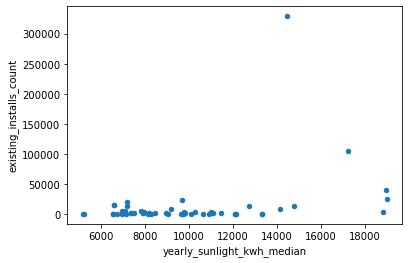

In [10]:
# it looks like the median kW is not correlated with the existing installs -- let's take a look
df.plot.scatter(x='yearly_sunlight_kwh_median', y='existing_installs_count')

In [11]:
# let's see what those outliers are
df[df['existing_installs_count'] > 50000]

,state_name,number_of_panels_total,kw_total,kw_median,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,existing_installs_count
5,California,531022657,1.327557e+08,9.75,14460.077979,1.980163e+11,328899.0
10,Florida,305682374,7.642059e+07,12.75,17250.183057,1.050627e+11,104123.0


This makes sens, CA and FL are very solar-friendly in terms of policy, I believe.

In [12]:
df.sort_values(by='existing_installs_count')

,state_name,number_of_panels_total,kw_total,kw_median,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,existing_installs_count
0,NaN,31,7.750000e+00,3.25,5209.464685,1.243764e+04,0.0
21,South Dakota,5162611,1.290653e+06,7.75,9741.482898,1.610011e+09,21.0
14,North Dakota,7273416,1.818354e+06,9.75,10901.191687,2.069036e+09,24.0
30,Wyoming,3249883,8.124708e+05,7.75,10645.344800,1.108615e+09,29.0
28,West Virginia,6414155,1.603539e+06,7.00,8128.741748,1.857681e+09,80.0
2,Alaska,2179124,5.447810e+05,7.25,6540.612622,4.664927e+08,83.0
8,Delaware,1985389,4.963472e+05,8.00,9746.691431,6.068660e+08,90.0
25,Vermont,1517792,3.794480e+05,6.50,7115.722705,4.203384e+08,131.0
7,Nebraska,19400445,4.850111e+06,7.50,9624.277734,6.101929e+09,208.0
4,Arkansas,28130196,7.032549e+06,9.75,12099.947974,8.941609e+09,238.0


In [13]:
# let's check for duplicated values
df.duplicated().sum()

3

In [14]:
# looks like we have some duplicated states in there, we should drop those
# keep=False means it marks all duplicates as True, so shows all duplicated rows
df[df.duplicated(keep=False)]

,state_name,number_of_panels_total,kw_total,kw_median,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,existing_installs_count
1,Massachusetts,52098838,13024709.50,5.75,6571.621021,1.486191e+10,15331.0
2,Michigan,96360897,24090224.25,6.75,7350.628174,2.695720e+10,1727.0
3,Minnesota,51738380,12934595.00,7.00,7896.430273,1.481478e+10,1519.0
31,Massachusetts,52098838,13024709.50,5.75,6571.621021,1.486191e+10,15331.0
32,Michigan,96360897,24090224.25,6.75,7350.628174,2.695720e+10,1727.0
33,Minnesota,51738380,12934595.00,7.00,7896.430273,1.481478e+10,1519.0


In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.shape

(52, 7)

In [17]:
# let's fill the missing values now
imputer = KNNImputer(n_neighbors=2)
state_names = df[['state_name']]  # indexing a single column with a list keeps it as a DataFrame instead of a Series
numeric_df = df.drop('state_name', axis=1)
imputed = imputer.fit_transform(numeric_df)
numeric_df[numeric_df.columns] = imputed
df = pd.concat([state_names, numeric_df], axis=1)

In [18]:
# looks like we successfully filled the missing values
df.isna().sum()

state_name                    1
number_of_panels_total        0
kw_total                      0
kw_median                     0
yearly_sunlight_kwh_median    0
yearly_sunlight_kwh_total     0
existing_installs_count       0
dtype: int64

In [19]:
df.to_excel('cleaned_solar_data.xlsx', index=False)

Summary:

The data is very small, with each US state, DC, and one unknown location having data. Most of the data is left-skewed with some large outliers. A few large outliers are CA and FL, which have a lot of installed solar panels.
We also see some strong correlations between certain columns of data. For example, the yearly kW total, number of panels, and existing installs count were strongly correcated, the kWh and kW median columns were weakly correlated to everything else. Some duplicates were detected in the data and were removed, and some missing values filled in with KNN imputation. Then the data was saved to an Excel file for further use.